In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.append('../')
import velovae as vv

# Define input and output file paths

In [5]:
dataset = "Pancreas"
filenames = {
    "Braindev": "/nfs/turbo/umms-welchjd/yichen/data/scRNA/Braindev_out.h5ad",
    "Blood": "/nfs/turbo/umms-welchjd/yichen/data/scRNA/Blood_out.h5ad",
    "Brain10x": "../data/Brain10x/Brain10x_out.h5ad",
    "Dentategyrus": "../data/Dentategyrus/Dentategyrus_out.h5ad",
    "Pancreas": "../data/Pancreas/Pancreas_out.h5ad"
}
model_path_base = f"../checkpoints/{dataset}"
figure_path_base = f"../figures/{dataset}"
data_path_base = {
    "Braindev": "/nfs/turbo/umms-welchjd/yichen/data/scRNA",
    "Blood": "/nfs/turbo/umms-welchjd/yichen/data/scRNA",
    "Brain10x": "../data/Brain10x",
    "Dentategyrus": "../data/Dentategyrus",
    "Pancreas": "../data/Pancreas"
}

in_name = filenames[dataset]
out_name = f"{dataset}_out.h5ad"

adata = anndata.read_h5ad(in_name)
if(dataset=="Braindev"):
    adata.obs['tprior'] = adata.obs['tprior'] - adata.obs['tprior'].min() + 0.01
if(dataset=="Blood"):
    adata.obs['clusters'] = adata.obs['leiden'].to_numpy()

In [ ]:
adata.X.shape

In [ ]:
Ngene = 1000
vv.preprocess(adata, Ngene, n_neighbors=100)

In [ ]:
scv.pl.scatter(adata, basis='umap', save=figure_path_base+"/umap.png")

In [ ]:
adata.X.shape

In [ ]:
np.all(adata.uns["vae_train_idx"]==adata.uns["vaepp_train_idx"])

In [ ]:
adata2 = anndata.read_h5ad(data_path_base[dataset]+"/Blood_pp.h5ad")


In [3]:
adata

AnnData object with n_obs × n_vars = 11605 × 1000
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'S_score', 'G2M_score', 'phase', 'fraction_u', 'leiden', 'root_prediction', 'total_s', 'total_u', 'total_Ms', 'total_Mu', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'vae_time', 'vae_std_t', 'vae++_time', 'vae++_std_t', 'vae++_t0', 'vae++_velocity_self_transition', 'vaepp_time', 'vaepp_std_t', 'vaepp_t0', 'vaepp2_time', 'vaepp2_std_t', 'vaepp2_t0'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_s

# (Optional) Run scVelo

In [ ]:
scv.tl.umap(adata)
scv.pl.scatter(adata, basis='umap', save=figure_path_base+"/umap.png")

In [ ]:
adata.uns["neighbors"]

In [ ]:
scv.tl.recover_dynamics(adata)
scv.tl.latent_time(adata)

In [ ]:
adata.write_h5ad(data_path_base[dataset]+"/"+f"{dataset}_pp.h5ad")

# Train a VeloVAE Model

In [ ]:
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base[dataset]

In [ ]:
def sampleGenes(adata, n, key, mode='top',q=0.5):
    if(mode=='random'):
        return np.random.choice(adata.var_names, n, replace=False)
    val_sorted = adata.var[key].sort_values(ascending=False)
    genes_sorted = val_sorted.index.to_numpy()
    if(mode=='threshold'):
        N = np.sum(val_sorted.to_numpy()>=q)
        return np.random.choice(genes_sorted[:N], min(n,N), replace=False)
    return genes_sorted[:n]
gene_plot = sampleGenes(adata, 4, 'fit_likelihood', 'top')
gene_plot

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
config = {
    #Model Parameters
    "tmax":10,
    "hidden_size":(500,250),
    "tprior":None,
    "tkey":None,
    #Training Parameters
    "N_epochs":800, 
    "N_warmup":5,
    "learning_rate":2e-4, 
    "learning_rate_ode":2e-4, 
    "lambda":1e-3,  
    "batch_size":128,
    "train_test_split":0.7,
}

vae = vv.VanillaVAE(adata, config['tmax'], hidden_size=config['hidden_size'], tprior=config['tprior'], device='cuda:0')

In [ ]:
vae.train(adata, config=config, gene_plot=gene_plot, figure_path=figure_path)

In [ ]:
vae.saveModel(model_path)
vae.saveAnnData(adata, 'vae', data_path, file_name=out_name)

In [ ]:
with open(figure_path+'/config.txt','w') as f:
    for key in vae.config:
        f.write(key+'\t'+str(vae.config[key])+'\n')

# Train a VAE++

In [ ]:
figure_path = figure_path_base+"/VAEpp2"
model_path = model_path_base+"/VAEpp2"
data_path = data_path_base[dataset]

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
config = {
    "tmax":30,
    "Cz":5,
    "hidden_size":(500, 250, 250, 500),
    "tprior":None,
    "tkey":None,
    "n_neighbors":15,
    "dt": (0.03,0.06),
    #Training Parameters
    "N_epochs":400,
    "N_epochs_post":400,
    "N_warmup":5,
    "N_warmup_post":5,
    "learning_rate":2e-4, 
    "learning_rate_ode":2e-4, 
    "learning_rate_post":2e-4,
    "lambda":1e-8,
    "lambda_rho":1e-8,
    "reg_t":1.0, 
    "reg_z":1.0, 
    "neg_slope":0.0, 
    "batch_size":512,
    "train_test_split":0.7,
}
#tmax = adata.obs.vanilla_time.max()
model = vv.VanillaVAEpp(adata, 
                        config['tmax'], 
                        config['Cz'], 
                        device='cuda:0', 
                        hidden_size=config['hidden_size'], 
                        tprior=config['tprior'], 
                        tkey=config['tkey'])
#model.decoder.ton = torch.nn.Parameter(torch.ones(adata.n_vars, device=model.device).float()*(-10))

In [ ]:
model.train(adata, config=config, plot=True, gene_plot=gene_plot, figure_path=figure_path)

In [ ]:
model.saveModel(model_path, 'encoder_vaepp2', 'decoder_vaepp2')
model.saveAnnData(adata, 'vaepp2', data_path, file_name=out_name)

In [ ]:
with open(figure_path+'/config.txt','w') as f:
    for key in model.config:
        f.write(key+'\t'+str(model.config[key])+'\n')

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'lime', 'grey', \
   'olive', 'cyan', 'pink', 'gold', 'steelblue', 'salmon', 'teal', \
   'magenta', 'rosybrown', 'darkorange', 'yellow', 'greenyellow', 'darkseagreen', 'yellowgreen', 'palegreen', \
   'hotpink', 'navajowhite', 'aqua', 'navy', 'saddlebrown', 'black', 'maroon']

In [ ]:
key = 'vaepp2'
z = adata.obsm[f'{key}_z']
t = adata.obs[f'{key}_time'].to_numpy()
t0 = adata.obs[f'{key}_t0'].to_numpy()
U0 = adata.layers[f'{key}_u0']
S0 = adata.layers[f'{key}_s0']
rho = adata.layers[f'{key}_rho']
ton = adata.var[f'{key}_ton'].to_numpy()
toff = adata.var[f'{key}_toff'].to_numpy()
V = adata.layers[f"{key}_velocity"]
Uhat = adata.layers[f"{key}_uhat"]
Shat = adata.layers[f"{key}_shat"]

cell_labels = adata.obs['clusters'].to_numpy()
cell_types = np.unique(cell_labels)

In [ ]:
pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho)

In [ ]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(10, 30)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(figure_path_base+'/rho_pca.png')

In [ ]:
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25)
z_umap = umap_obj.fit_transform(z)

In [ ]:
fig=plt.figure(figsize=(10,10))
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.show()
fig.savefig(figure_path_base+'/z_umap.png')

In [ ]:
gidx = np.where(adata.var_names==gene_plot[2])[0][0]
name = adata.var_names[gidx]
v = V[:, gidx]
uhat = Uhat[:, gidx]
shat = Shat[:, gidx]
dt = 0.2
s_ = shat + v*dt

fig, ax = plt.subplots(figsize=(10,8))
for i,x in enumerate(cell_types):
    ax.quiver(t[cell_labels==x][::10], shat[cell_labels==x][::10], dt*np.ones((len(t[cell_labels==x][::10]))), v[cell_labels==x][::10]*dt, angles='xy', scale=1.0, scale_units='inches', headwidth=5.0, headlength=8.0, color=colors[i], label=x)
ax.set_title(name)
ax.legend(bbox_to_anchor=(1.05,1.0), loc='upper left')
fig.show()
#fig.savefig(figure_path_base+f'/{name}_{key}_vel.png', bbox_inches='tight')

In [ ]:
v = V[:, gidx]
u = adata.layers["Mu"][:,gidx]
s = adata.layers["Ms"][:,gidx]
uhat = Uhat[:, gidx]
shat = Shat[:, gidx]
s0 = S0[:,gidx]
dt = 0.2
s_ = shat + v*dt
print(np.mean(np.abs(t0-t)))

fig, ax = plt.subplots()
D = 503
for i,x in enumerate(cell_types):
    for j in range(len(t[cell_labels==x][::D])):
        #print(x, t[cell_labels==x][::D][j]-t0[cell_labels==x][::D][j], shat[cell_labels==x][::D][j]-s0[cell_labels==x][::D][j], v[cell_labels==x][::D][j])
        ax.plot([t0[cell_labels==x][::D][j], t[cell_labels==x][::D][j]], [s0[cell_labels==x][::D][j],shat[cell_labels==x][::D][j]], 'k-o')
    ax.quiver(t[cell_labels==x][::D], shat[cell_labels==x][::D], dt*np.ones((len(t[cell_labels==x][::D]))), v[cell_labels==x][::D]*dt, angles='xy', scale=1.0, scale_units='inches', headwidth=3.0, headlength=5.0, color=colors[i], label=x)
ax.set_title(name)
ax.legend(bbox_to_anchor=(1.05,1.0), loc='upper left')
fig.show()
fig.savefig(figure_path_base+f'/{name}_{key}_x0.png', bbox_inches='tight')

# Down-stream Analysis

In [ ]:
methods = ['scVelo','Vanilla VAE','VAE']
keys = ['fit','vae','vaepp']
plot_type = []

In [ ]:
n_row = int(np.sqrt(len(gene_plot)))
if(n_row**2==len(gene_plot)):
    n_col = n_row
else:
    n_col = len(gene_plot)//n_row 
    n_col += int(n_col*n_row < len(gene_plot))
grid_size = (n_row,n_col)

In [ ]:
grid_size = (1,1)
vv.postAnalysis(adata, methods, keys, [], plot_type, Nplot=100, embed="umap", grid_size=grid_size, save_path=figure_path_base)

In [ ]:
from scipy.stats import spearmanr
tprior = adata.obs["tprior"].to_numpy()
t_scv = adata.obs["latent_time"].to_numpy()
t_vae = adata.obs["vae_time"].to_numpy()
t_vaepp = adata.obs["vaepp_time"].to_numpy()
t_vaepp2 = adata.obs["vaepp2_time"].to_numpy()
print(spearmanr(tprior, t_scv))
print(spearmanr(tprior, t_vae))
print(spearmanr(tprior, t_vaepp))
print(spearmanr(tprior, t_vaepp2))

In [ ]:
import scvelo as scv
scv.tl.velocity_graph(adata, vkey='fit_velocity')
scv.tl.velocity_embedding(adata, vkey='fit_velocity')
scv.pl.velocity_embedding_stream(adata, vkey='fit_velocity', figsize=(8,6), dpi=160, save=f'{figure_path_base}/{dataset}_velocity_scv.png')

computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:30) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/Pancreas/Pancreas_velocity_vae.png


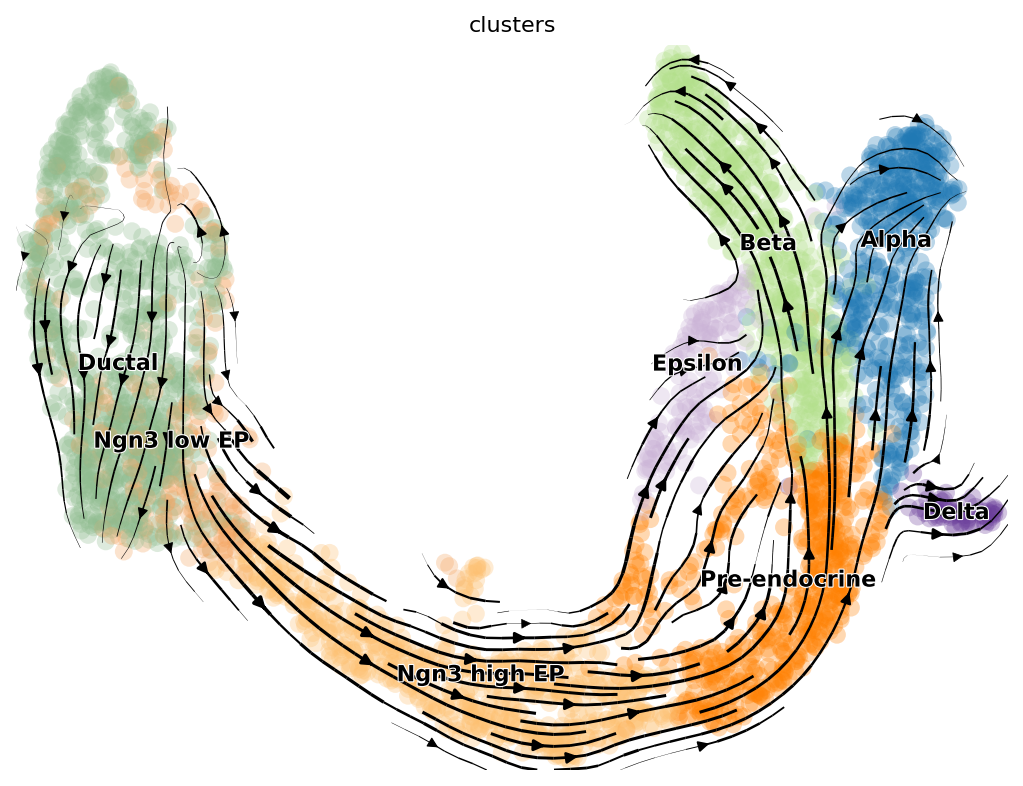

In [6]:
key = 'vae'
vv.rnaVelocityVAE(adata, key, use_scv_genes=False)
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', figsize=(8,6), dpi=160, save=f'{figure_path_base}/{dataset}_velocity_vae.png')

computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:30) --> added 
    'vaepp2_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vaepp2_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/Pancreas/Pancreas_velocity_vaepp2.png


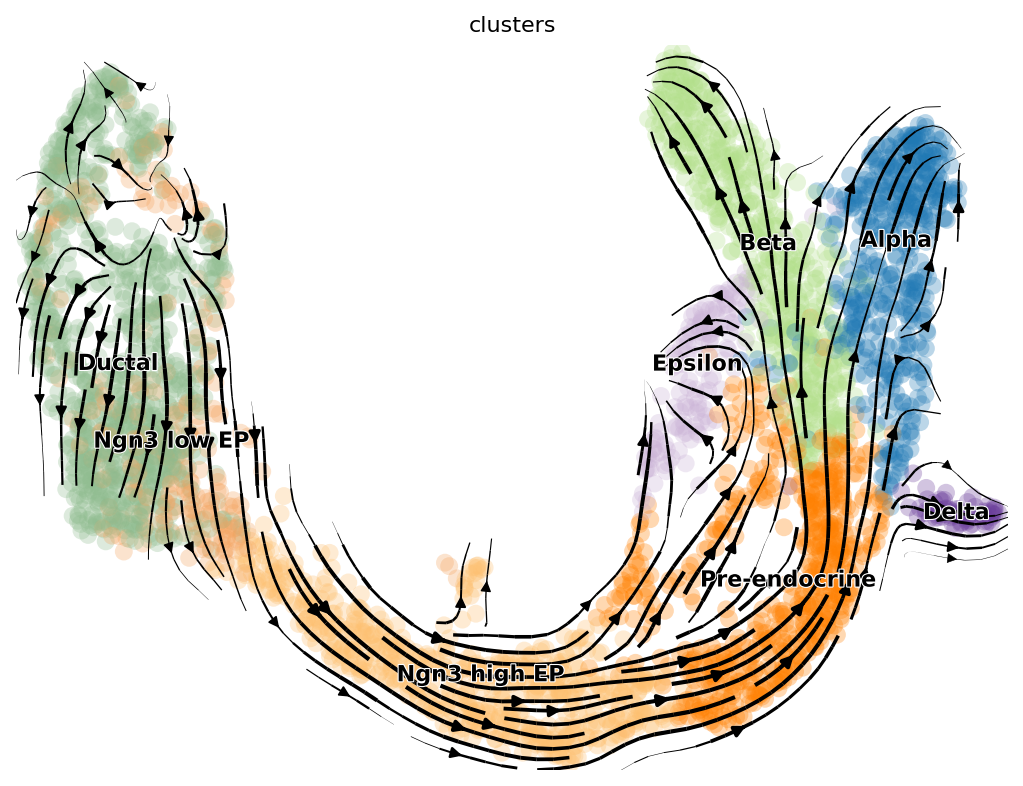

In [8]:
key = 'vaepp2'
vv.rnaVelocityVAEpp(adata, key, use_scv_genes=False, sigma=None, approx=False)
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', figsize=(8,6), dpi=160, save=f'{figure_path_base}/{dataset}_velocity_{key}.png')

In [9]:
adata = scv.read("/nfs/turbo/umms-welchjd/chen/data/HSPC_3423-MV-2/velocyto/gex_possorted_bam_ICXFB.loom", cache=True)
adata.var_names_make_unique()
adata.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata.obs_names]

sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_cells(adata, max_counts=17500)

sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata = adata[(adata.obs['n_genes_by_counts'] < 5000) & (adata.obs['n_genes_by_counts'] > 1000),:]
scv.pp.filter_genes(adata, min_shared_counts=10)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=1000)
scv.pp.log1p(adata)
scv.tl.score_genes_cell_cycle(adata)

counts_s = scv.utils.sum_var(adata.layers['spliced'])
counts_u = scv.utils.sum_var(adata.layers['unspliced'])
fraction_u = counts_u / (counts_s + counts_u)
adata.obs['fraction_u'] = fraction_u
sc.pp.regress_out(adata, ['S_score', 'G2M_score', 'fraction_u'])
sc.pp.scale(adata)

scv.pp.moments(adata, n_pcs=30, n_neighbors=50)
scv.tl.umap(adata)

#sc.tl.leiden(adata, resolution=1.05)
#sc.pl.umap(adata, color='leiden')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Trying to set attribute `.obs` of view, copying.


Filtered out 25238 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.


... storing 'phase' as categorical


Extracted 1000 highly variable genes.
calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)
computing neighbors
    finished (0:00:21) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/40 cores)


  0%|          | 0/622 [00:00<?, ?gene/s]